In [2]:
# For reference   

 # info_dict = {
    #     "game_id": unique_game_id,
    #     "transcript": game_state,
    #     "result": result,
    #     "player_one": player_one_title,
    #     "player_two": player_two_title,
    #     "player_one_score": player_one_score,
    #     "player_two_score": player_two_score,
    #     "player_one_illegal_moves": player_one_illegal_moves,
    #     "player_two_illegal_moves": player_two_illegal_moves,
    #     "player_one_resignation": player_one_resignation,
    #     "player_two_resignation": player_two_resignation,
    #     "game_title": f"{player_one_title} vs. {player_two_title}",
    #     "number_of_moves": board.fullmove_number,
    #     "time_taken": total_time,
    # }

In [3]:
import os
GRID_SEARCH_DIR = "logs/grid_search/"

for file in os.listdir(GRID_SEARCH_DIR):
    print(file)

lichess_16layers_ckpt_no_optimizer_pt_0_random_moves_vs_stockfish_sweep.csv
lichess_16layers_ckpt_no_optimizer_pt_10_random_moves_vs_stockfish_sweep.csv
lichess_16layers_ckpt_no_optimizer_pt_20_random_moves_vs_stockfish_sweep.csv
lichess_16layers_ckpt_no_optimizer_pt_5_random_moves_vs_stockfish_sweep.csv
lichess_200k_bins_16layers_ckpt_no_optimizer_pt_0_random_moves_vs_stockfish_sweep.csv
lichess_200k_bins_16layers_ckpt_no_optimizer_pt_10_random_moves_vs_stockfish_sweep.csv
lichess_200k_bins_16layers_ckpt_no_optimizer_pt_20_random_moves_vs_stockfish_sweep.csv
lichess_200k_bins_16layers_ckpt_no_optimizer_pt_5_random_moves_vs_stockfish_sweep.csv
lichess_200k_bins_train_layer_11_pos_start_25_levels_04_activations_pt_0_random_moves_0_1_coefficient_vs_stockfish_sweep.csv
lichess_200k_bins_train_layer_11_pos_start_25_levels_04_activations_pt_0_random_moves_0_3_coefficient_vs_stockfish_sweep.csv
lichess_200k_bins_train_layer_11_pos_start_25_levels_04_activations_pt_0_random_moves_0_5_coeffici

In [4]:
import pandas as pd
import os
import numpy as np

def compute_average_score(file_path: str, player: str = "player_one") -> float:
    file_path = os.path.join(GRID_SEARCH_DIR, file_path)
    df = pd.read_csv(file_path)
    # df = df[df['game_title'].str.contains("Stockfish 1")]
    df[f"{player}_score"] = pd.to_numeric(df[f"{player}_score"], errors="coerce")
    average_scores = df.groupby("game_title")[f"{player}_score"].mean()
    return np.mean(average_scores)

# List all CSV files
csv_files = [f for f in os.listdir(GRID_SEARCH_DIR) if f.endswith('.csv')]

# Dictionary to hold file names and their average scores
average_scores_dict = {}

for file in csv_files:
    try:
        if "10_random_moves" not in file:
            continue
        avg_score = compute_average_score(file)
        average_scores_dict[file] = avg_score
    except Exception as e:
        print(f"Error processing file {file}: {e}")

# Sort the files by average score
sorted_files = sorted(average_scores_dict.items(), key=lambda x: x[1], reverse=True)

# Print sorted files and their scores
for file, score in sorted_files:
    if file.startswith("lichess_train"):
        file = file.replace("lichess_train", "lichess_000k_bins_train")
    print(f"{file}: {score}")


lichess_000k_bins_train_layer_11_pos_start_25_levels_05_activations_pt_lichess_000k_bins_train_layer_12_pos_start_25_levels_05_activations_pt_lichess_000k_bins_train_layer_13_pos_s_10_random_moves_0_1_coefficient_vs_stockfish_sweep.csv: 0.4571687370600414
lichess_000k_bins_train_layer_11_pos_sta_lichess_000k_bins_train_layer_12_pos_sta_lichess_000k_bins_train_layer_13_pos_sta_lichess_000k_bins_train_layer_14_pos_sta__10_random_moves_0_15_coefficient_vs_stockfish_sweep.csv: 0.4009846678521624
lichess_000k_bins_train_layer_11_pos_sta_lichess_000k_bins_train_layer_12_pos_sta_lichess_000k_bins_train_layer_13_pos_sta_lichess_000k_bins_train_layer_14_pos_sta__10_random_moves_0_1_coefficient_vs_stockfish_sweep.csv: 0.3994028306766351
lichess_000k_bins_train_layer_13_pos_start_25_levels_05_activations_pt__10_random_moves_0_5_coefficient_vs_stockfish_sweep.csv: 0.38811198446615114
lichess_200k_bins_train_layer_11_pos_start_25_levels_14_activations_pt_ain_layer_12_pos_sta_ain_layer_13_pos_sta_ai

In [10]:
import pandas as pd
import os
import numpy as np
from scipy.stats import sem, t

def compute_average_score_and_confidence_interval(file_path: str, player: str = "player_one", confidence=0.95) -> dict:
    file_path = os.path.join(GRID_SEARCH_DIR, file_path)
    df = pd.read_csv(file_path)

    # Filter rows where 'Stockfish -1' is in 'game_title'
    # df = df[df['game_title'].str.contains("Stockfish 0")]
    df = df[~df['game_title'].str.contains("Stockfish -1")]

    # df = df[df['player_one_failed_to_find_legal_move'] == False]

    total_moves = len(df)
    successful_moves = df[df[f'{player}_failed_to_find_legal_move'] == False].shape[0]
    percentage_successful = (successful_moves / total_moves) * 100

    df[f"{player}_score"] = pd.to_numeric(df[f"{player}_score"], errors="coerce")

    # Compute overall average score and confidence interval
    scores = df[f"{player}_score"].dropna()
    if len(scores) > 1:
        mean_score = np.mean(scores)
        std_err = sem(scores)
        h = std_err * t.ppf((1 + confidence) / 2, len(scores) - 1)
        result = {"mean_score": mean_score, "confidence_interval": (mean_score - h, mean_score + h)}
    else:
        result = {"mean_score": scores.iloc[0], "confidence_interval": (np.nan, np.nan)}

    result["percentage_successful"] = percentage_successful
    result["total_moves"] = total_moves

    # print(result)

    return result

    # # Compute average scores and confidence intervals
    # results = {}
    # for game_title, group in df.groupby("game_title"):
    #     scores = group[f"{player}_score"].dropna()
    #     if len(scores) > 1:
    #         mean_score = np.mean(scores)
    #         std_err = sem(scores)
    #         h = std_err * t.ppf((1 + confidence) / 2, len(scores) - 1)
    #         results[game_title] = {"mean_score": mean_score, "confidence_interval": (mean_score - h, mean_score + h)}
    #     else:
    #         results[game_title] = {"mean_score": scores.iloc[0], "confidence_interval": (np.nan, np.nan)}

    # print(results)
    # return results

# List all CSV files
csv_files = [f for f in os.listdir(GRID_SEARCH_DIR) if f.endswith('.csv')]

# Dictionary to hold file names and their average scores
results_dict = {}
average_scores_dict = {}

for file in csv_files:
    try:
        # if "10_random_moves" not in file:
        #     continue
        # if "0_1_coefficient" in file:
        #     continue
        if "levels_14" in file or "levels_15" in file or "levels_04" in file:
            continue
        if "200k" in file:
            continue
        if "pos_start_32" in file:
            continue
        if "20000_moves" in file:
            continue
        # if "layer_8" in file:
        #     continue
        # if "8layers" not in file and "layers_8" not in file:
        if "8layers" in file or "layers_8" in file:
            continue
        result = compute_average_score_and_confidence_interval(file)
        average_scores_dict[file] = result["mean_score"]
        results_dict[file] = result
    except Exception as e:
        print(f"Error processing file {file}: {e}")

# Sort the files by average score
sorted_files = sorted(average_scores_dict.items(), key=lambda x: x[1], reverse=True)

# Print sorted files and their scores
for file, score in sorted_files:
    if "10_random_moves" not in file:
        continue
    confidence_interval = results_dict[file]["confidence_interval"]
    total_moves = results_dict[file]["total_moves"]
    percentage_successful = results_dict[file]["percentage_successful"]
    # if file.startswith("lichess_train"):
    #     file = file.replace("lichess_train", "lichess_000k_bins_train")
    # if total_moves <= 100:
    #     continue

    print(f"{file}: {score}, {total_moves}, {percentage_successful}, {confidence_interval}")

print("\n\nBegin 0 random moves\n\n")
# Print sorted files and their scores
for file, score in sorted_files:
    if "_0_random_moves" not in file:
        continue
    confidence_interval = results_dict[file]["confidence_interval"]
    total_moves = results_dict[file]["total_moves"]
    percentage_successful = results_dict[file]["percentage_successful"]
    # if file.startswith("lichess_train"):
    #     file = file.replace("lichess_train", "lichess_000k_bins_train")
    # if total_moves <= 100:
    #     continue

    print(f"{file}: {score}, {total_moves}, {percentage_successful}, {confidence_interval}")


tf_lens_lichess_8layers_ckpt_no_optimizer_chess_skill_probe_layer_6_activation_pt__10_random_moves_0_5_coefficient_vs_stockfish_sweep.csv: 0.21370967741935484, 400, 86.0, (0.1721126126454498, 0.2553067421932599)
tf_lens_lichess_8layers_ckpt_no_optimizer_chess_skill_probe_layer_6_activation_pt__10_random_moves_0_3_coefficient_vs_stockfish_sweep.csv: 0.2032967032967033, 400, 83.5, (0.16300933048820188, 0.24358407610520472)
lichess_train_n_layers_8_layer_3_pos_start_25_levels_05_activations_pt__10_random_moves_0_5_coefficient_vs_stockfish_sweep.csv: 0.12670299727520437, 400, 93.25, (0.09390807234833912, 0.15949792220206963)
lichess_train_n_layers_8_layer_2_pos_start_25_levels_05_activations_pt__10_random_moves_0_3_coefficient_vs_stockfish_sweep.csv: 0.12054794520547946, 400, 93.5, (0.08831451653997854, 0.15278137387098037)
lichess_train_n_layers_8_layer_0_pos_start_25_levels_05_activations_pt__10_random_moves_0_3_coefficient_vs_stockfish_sweep.csv: 0.12044817927170869, 400, 93.5, (0.08789

In [6]:
print(sorted_files)

[('lichess_train_layer_13_pos_start_25_levels_05_activations_pt__10_random_moves_0_5_coefficient_vs_stockfish_sweep.csv', 0.3795620437956204), ('lichess_train_layer_11_pos_start_25_levels_05_activations_20000_moves_pt__10_random_moves_0_3_coefficient_vs_stockfish_sweep.csv', 0.35602094240837695), ('lichess_train_layer_14_pos_start_25_levels_04_activations_pt_10_random_moves_0_5_coefficient_vs_stockfish_sweep.csv', 0.35294117647058826), ('lichess_train_layer_14_pos_start_25_levels_05_activations_20000_moves_pt__10_random_moves_0_3_coefficient_vs_stockfish_sweep.csv', 0.3526570048309179), ('lichess_train_layer_14_pos_start_25_levels_05_activations_20000_moves_pt__10_random_moves_0_5_coefficient_vs_stockfish_sweep.csv', 0.3474178403755869), ('lichess_train_layer_14_pos_start_25_levels_05_activations_pt_10_random_moves_0_5_coefficient_vs_stockfish_sweep.csv', 0.32857142857142857), ('lichess_200k_bins_train_layer_14_pos_start_25_levels_04_activations_pt_10_random_moves_0_3_coefficient_vs_st

In [37]:
import re
from collections import defaultdict
from typing import List, Dict, Tuple

def modify_filename(filename: str, variable: str) -> Tuple[str, str]:
    # Use regex to replace the variable value with 'xx'
    pattern = fr"({variable}_)(\d+)"
    # pattern = fr"(\d+)(_{variable})"

    original_value = re.search(pattern, filename)
    if original_value:
        modified_filename = re.sub(pattern, fr"\1xx", filename)
        return modified_filename, original_value.group(2)
    return filename, ""

def group_by_single_variable_change(sorted_files: List[Tuple[str, any]], variable: str) -> Dict[str, List[Tuple[str, str, any]]]:
    grouped_files = defaultdict(list)
    for filename, *other_data in sorted_files:
        modified_filename, original_value = modify_filename(filename, variable)
        grouped_files[modified_filename].append((filename, original_value, *other_data))
    return grouped_files

# Example usage:
# sorted_files = [
#     # Your list of tuples here. Each tuple should at least have a filename
# ]
variable = "random_moves"  # Change this to the variable you want to focus on
variable = "pt"
# variable = "pos_start"
grouped = group_by_single_variable_change(sorted_files, variable)

for modified_filename, file_info in grouped.items():
    if len(file_info) > 0:
        if "200k" not in modified_filename:
            continue
        print(f"{modified_filename}:")
        for info in file_info:
            original_filename, value, *additional_data = info
            score = additional_data[0] if additional_data else None  # Assuming the score is the first item in additional_data
            print(f"  Original: {original_filename}, Value: {value}, Score: {score}")


In [14]:
import pandas as pd
import os
import numpy as np
from scipy.stats import sem, t

def compute_percentage_of_successful_moves(file_path: str, player: str = "player_one", confidence=0.9) -> dict:
    """
    Computes the percentage of successful moves and confidence interval for a given player.

    :param file_path: Path to the CSV file containing game data.
    :param player: The player for whom to compute the statistics (default is 'player_one').
    :param confidence: Confidence level for the interval calculation (default is 0.95).
    :return: A dictionary with the percentage of successful moves and the confidence interval.
    """
    file_path = os.path.join(GRID_SEARCH_DIR, file_path)
    df = pd.read_csv(file_path)

    # Filter rows where 'Stockfish 0' is in 'game_title'
    # df = df[df['game_title'].str.contains("Stockfish 0")]

    # Calculate the percentage of successful moves
    total_moves = len(df)
    successful_moves = df[df[f'{player}_failed_to_find_legal_move'] == False].shape[0]
    percentage_successful = (successful_moves / total_moves) * 100

    # Compute confidence interval for the proportion
    proportion = successful_moves / total_moves
    std_err = np.sqrt(proportion * (1 - proportion) / total_moves)
    h = std_err * t.ppf((1 + confidence) / 2, total_moves - 1)
    confidence_interval = (proportion - h, proportion + h)

    return {
        "percentage_successful": percentage_successful,
        "confidence_interval": (confidence_interval[0] * 100, confidence_interval[1] * 100)
    }

    # # Compute average scores and confidence intervals
    # results = {}
    # for game_title, group in df.groupby("game_title"):
    #     scores = group[f"{player}_score"].dropna()
    #     if len(scores) > 1:
    #         mean_score = np.mean(scores)
    #         std_err = sem(scores)
    #         h = std_err * t.ppf((1 + confidence) / 2, len(scores) - 1)
    #         results[game_title] = {"mean_score": mean_score, "confidence_interval": (mean_score - h, mean_score + h)}
    #     else:
    #         results[game_title] = {"mean_score": scores.iloc[0], "confidence_interval": (np.nan, np.nan)}

    # print(results)
    # return results

# List all CSV files
csv_files = [f for f in os.listdir(GRID_SEARCH_DIR) if f.endswith('.csv')]

# Dictionary to hold file names and their average scores
average_scores_dict = {}
confidence_interval_dict = {}

for file in csv_files:
    try:
        if "10_random_moves" in file:
            continue
        # if "0_1_coefficient" in file:
        #     continue
        if "pos_start_32" in file:
            continue
        result = compute_percentage_of_successful_moves(file)
        confidence_interval_dict[file] = result["confidence_interval"]
        average_scores_dict[file] = result["percentage_successful"]
    except Exception as e:
        print(f"Error processing file {file}: {e}")

# Sort the files by average score
sorted_files = sorted(average_scores_dict.items(), key=lambda x: x[1], reverse=True)

# Print sorted files and their scores
for file, score in sorted_files:
    confidence_interval = confidence_interval_dict[file]
    if file.startswith("lichess_train"):
        file = file.replace("lichess_train", "lichess_000k_bins_train")

    print(f"{file}: {score}, {confidence_interval}")


tf_lens_lichess_16layers_ckpt__tf_lens_lichess_16layers_ckpt__tf_lens_lichess_16layers_ckpt__tf_lens_lichess_16layers_ckpt___0_random_moves_0_15_coefficient_vs_stockfish_sweep.csv: 98.66666666666667, (97.11661958053386, 100.21671375279948)
tf_lens_lichess_16layers_ckpt__tf_lens_lichess_16layers_ckpt__tf_lens_lichess_16layers_ckpt__tf_lens_lichess_16layers_ckpt___0_random_moves_0_1_coefficient_vs_stockfish_sweep.csv: 98.66666666666667, (97.11661958053386, 100.21671375279948)
lichess_000k_bins_train_layer_11_pos_start_25_levels_04_activations_pt_0_random_moves_0_1_coefficient_vs_stockfish_sweep.csv: 97.33333333333334, (95.15609757188928, 99.5105690947774)
lichess_000k_bins_train_layer_14_pos_start_25_levels_14_activations_pt_0_random_moves_0_1_coefficient_vs_stockfish_sweep.csv: 97.33333333333334, (95.15609757188928, 99.5105690947774)
lichess_000k_bins_train_layer_8_pos_start_25_levels_14_activations_pt_0_random_moves_0_3_coefficient_vs_stockfish_sweep.csv: 97.33333333333334, (95.1560975

1207
[0.  1.  0.5 nan]
game_title
lichess_16_ckpt.pt vs. Stockfish -1    0.862637
lichess_16_ckpt.pt vs. Stockfish 0     0.520000
lichess_16_ckpt.pt vs. Stockfish 1     0.353261
lichess_16_ckpt.pt vs. Stockfish 10    0.010000
lichess_16_ckpt.pt vs. Stockfish 2     0.241573
lichess_16_ckpt.pt vs. Stockfish 3     0.172043
lichess_16_ckpt.pt vs. Stockfish 4     0.193548
lichess_16_ckpt.pt vs. Stockfish 5     0.093750
lichess_16_ckpt.pt vs. Stockfish 6     0.032258
lichess_16_ckpt.pt vs. Stockfish 7     0.005051
lichess_16_ckpt.pt vs. Stockfish 8     0.005051
lichess_16_ckpt.pt vs. Stockfish 9     0.005208
Name: player_one_score, dtype: float64


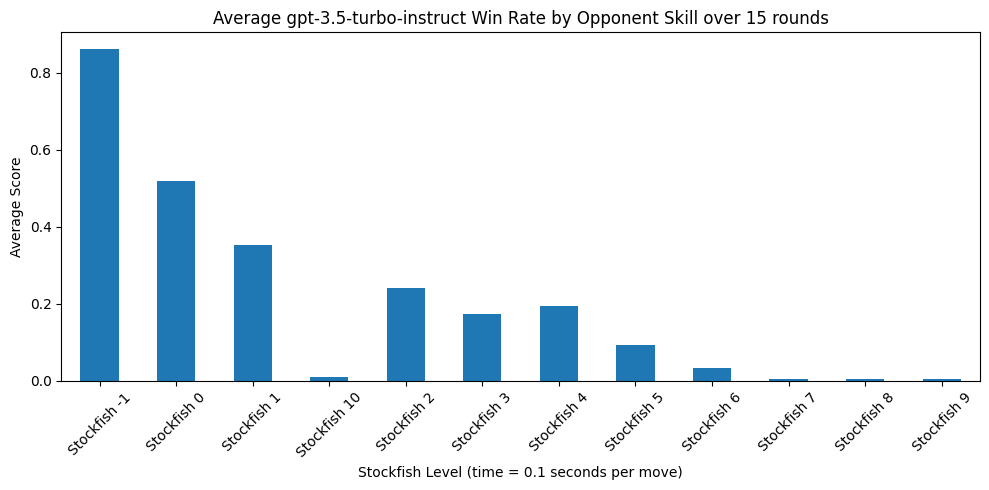

In [36]:
import pandas as pd
import matplotlib.pyplot as plt

def graph_player_gpt_score(player: str, df: pd.DataFrame) -> None:
    if player != "player_one" and player != "player_two":
        raise ValueError("player must be either 'player_one' or 'player_two'")
    
    # Convert the player_one_score column to numeric type (if it's not already)
    df[f"{player}_score"] = pd.to_numeric(df[f"{player}_score"], errors="coerce")
    print(df[f"{player}_score"].unique())

    # Compute average score of player_one grouped by game_title
    average_scores = df.groupby("game_title")[f"{player}_score"].mean()

    # Display the result
    print(average_scores)

    average_scores.index = average_scores.index.str.split(' vs. ').str[1].str.strip()

    average_scores.plot(kind="bar", figsize=(10, 5))
    plt.title(f"Average gpt-3.5-turbo-instruct Win Rate by Opponent Skill over 15 rounds")
    plt.ylabel("Average Score")
    plt.xlabel("Stockfish Level (time = 0.1 seconds per move)")
    plt.xticks(rotation=45)
    plt.tight_layout()
    # plt.show()
    plt.savefig("gpt-3.5-turbo-instruct-win-rate.png")

filename = "logs/ckpt_16_pt_vs_stockfish_sweep.csv"
filename = "logs/ckpt_8_pt_vs_stockfish_sweep.csv"
# filename = "logs/2325_lichess_ckpt_pt_vs_stockfish_sweep.csv"
# filename = "logs/ckpt_synthetic_split_no_opt_pt_vs_stockfish_sweep.csv"
filename = "logs/lichess_16_ckpt_pt_vs_stockfish_sweep.csv"
# filename = "logs/lichess_8layers_ckpt_no_optimizer_pt_vs_stockfish_sweep.csv"
# filename = "logs/lichess_stockfish_mix_8layers_ckpt_no_optimizer_pt_vs_stockfish_sweep.csv"
# filename = "logs/lichess_8layers_results_ckpt_no_optimizer_pt_vs_stockfish_sweep.csv"
# filename = "logs/12_25_01_coeff_pt_vs_stockfish_sweep.csv"
# filename = "logs/no_activation_pt_vs_stockfish_sweep copy.csv"
# filename = "logs/lichess_train_layer_12_pos_start_25_activations_pt_vs_stockfish_sweep.csv"
# filename = "logs/lichess_train_layer_12_pos_start_25_activations_pt_10_random_moves_vs_stockfish_sweep.csv"
# filename = "logs/no_activation_pt_10_random_moves_vs_stockfish_sweep.csv"
# filename = "logs/lichess_200k_bins_16layers_ckpt_no_optimizer_pt_vs_stockfish_sweep.csv"
df = pd.read_csv(filename)
print(len(df))

graph_player_gpt_score("player_one", df)


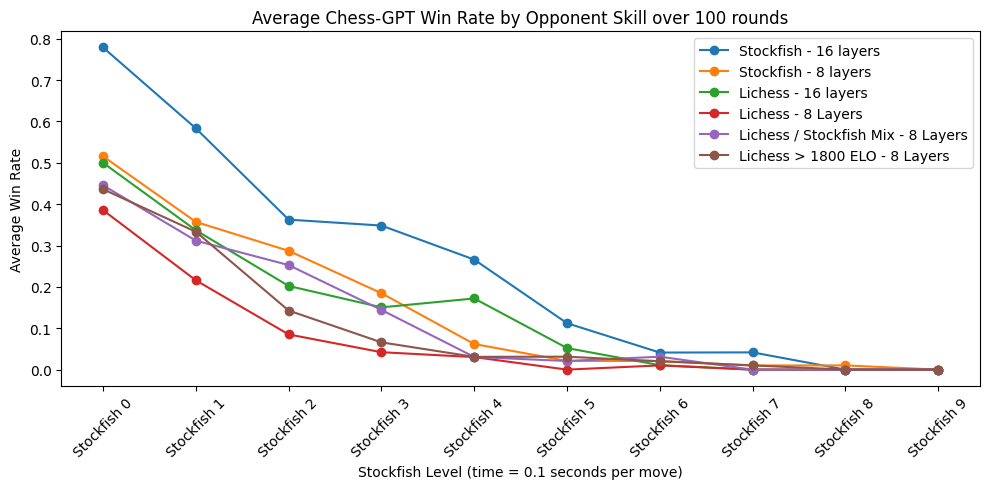

In [37]:
import pandas as pd
import matplotlib.pyplot as plt

def graph_player_gpt_scores(player: str, dfs: list[pd.DataFrame], labels: list[str]) -> None:
    if player != "player_one" and player != "player_two":
        raise ValueError("player must be either 'player_one' or 'player_two'")
    
    avg_scores_list = []

    for df in dfs:
        
        # Convert the player_score column to numeric type (if it's not already)
        df[f"modified_{player}_score"] = pd.to_numeric(df[f"modified_{player}_score"], errors="coerce")

        # Compute average score of player grouped by game_title
        avg_scores = df.groupby("game_title")[f"modified_{player}_score"].mean()
        avg_scores_list.append(avg_scores)

    # Plotting
    plt.figure(figsize=(10, 5))
    # for i, avg_scores in enumerate(avg_scores_list):
    #     avg_scores.index = avg_scores.index.str.split(' vs. ').str[1].str.strip()
    #     avg_scores.plot(kind="bar", position=i, label=labels[i])

    for df, label in zip(dfs, labels):
        df = df[df['player_two'] != 'Stockfish 10'].copy()
        # Convert the player_score column to numeric type (if it's not already)
        df[f"modified_{player}_score"] = pd.to_numeric(df[f"modified_{player}_score"], errors="coerce")

        # Compute average score of player grouped by game_title
        avg_scores = df.groupby("game_title")[f"modified_{player}_score"].mean()

        # Clean up the index for better labeling
        avg_scores.index = avg_scores.index.str.split(' vs. ').str[1].str.strip()

        # Plotting
        plt.plot(avg_scores, label=label, marker='o')  # Line chart with markers


    plt.title(f"Average Chess-GPT Win Rate by Opponent Skill over 100 rounds")
    plt.ylabel("Average Win Rate")
    plt.xlabel("Stockfish Level (time = 0.1 seconds per move)")
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.savefig("llm-win-rate.png")
    # plt.show()  # Uncomment this if you want to display the plot

# Example usage
filenames = [
"logs/ckpt_16_pt_vs_stockfish_sweep.csv",
"logs/ckpt_8_pt_vs_stockfish_sweep.csv",
# "logs/ckpt_synthetic_split_no_opt_pt_vs_stockfish_sweep.csv",
"logs/lichess_16_ckpt_pt_vs_stockfish_sweep.csv",
"logs/lichess_8layers_ckpt_no_optimizer_pt_vs_stockfish_sweep.csv",
"logs/lichess_stockfish_mix_8layers_ckpt_no_optimizer_pt_vs_stockfish_sweep.csv",
# "logs/lichess_8layers_results_ckpt_no_optimizer_pt_vs_stockfish_sweep.csv",
# "logs/lichess_8layers_results_ckpt_no_optimizer_pt_vs_stockfish_sweep_1-0.csv",
"logs/lichess_8layers_gt_18k_ckpt_no_optimizer_pt_vs_stockfish_sweep.csv"
]

dfs = [pd.read_csv(filename) for filename in filenames]
labels = ["Stockfish - 16 layers",
        "Stockfish - 8 layers",
        "Lichess - 16 layers",
        "Lichess - 8 Layers",
         "Lichess / Stockfish Mix - 8 Layers",
        #  "Lichess Results - 8 Layers",
        #  "Lichess Results - 8 Layers (1-0)",
         "Lichess > 1800 ELO - 8 Layers"]

graph_player_gpt_scores("player_one", dfs, labels)


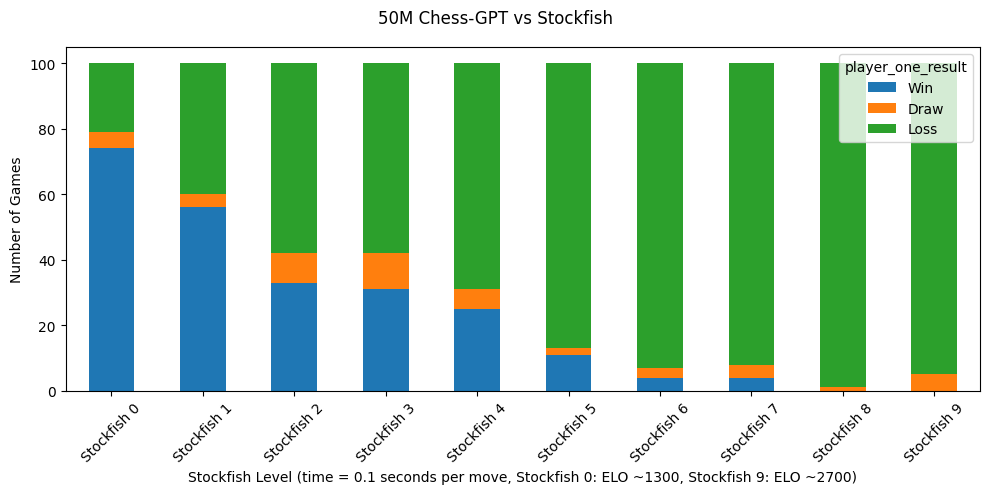

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

def graph_player_gpt_score(player: str, df: pd.DataFrame) -> None:
    if player not in ["player_one", "player_two"]:
        raise ValueError("player must be either 'player_one' or 'player_two'")
    
    # Convert the score column to numeric type (if it's not already)
    df[f"{player}_score"] = pd.to_numeric(df[f"{player}_score"], errors="coerce")
    df[f"modified_{player}_score"] = pd.to_numeric(df[f"modified_{player}_score"], errors="coerce")

    # Categorize each game result into win, loss, or draw
    def categorize(score):
        if score == 1:
            return 'Win'
        elif score == 0:
            return 'Loss'
        else:
            return 'Draw'
        
    df = df[df['player_two'] != 'Stockfish 10'].copy()

    df[f"{player}_result"] = df[f"modified_{player}_score"].apply(categorize)

    # Group by game title and result type, then count occurrences
    result_counts = df.groupby(["player_two", f"{player}_result"]).size().unstack().fillna(0)
    result_counts = result_counts[['Win', 'Draw', 'Loss']]

    # Create a stacked bar chart
    result_counts.plot(kind="bar", stacked=True, figsize=(10, 5))

    plt.suptitle(f"50M Chess-GPT vs Stockfish")
    # plt.title("Stockfish 0: ELO ~1300, Stockfish 9: ELO ~2700")
    plt.ylabel("Number of Games")
    plt.xlabel("Stockfish Level (time = 0.1 seconds per move, Stockfish 0: ELO ~1300, Stockfish 9: ELO ~2700)")
    # plt.text(0.5, -0.4, "Stockfish 0: ELO ~1300, Stockfish 9: ELO ~2700", ha='center', va='center', transform=plt.gca().transAxes)

    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f"50M-Chess-GPT-win-rate.png")

# Example usage
filename = "logs/ckpt_16_pt_vs_stockfish_sweep.csv"
df = pd.read_csv(filename)
graph_player_gpt_score("player_one", df)


In [ ]:
import pandas as pd
def analyze_move_history(df: pd.DataFrame, model: str, player: str) -> None:
    if player != "player_one" and player != "player_two":
        raise ValueError("player must be either 'player_one' or 'player_two'")
    
    model = df[player].unique()[0]

    # Filter the DataFrame for games where player title is model
    filtered_df = df[df[player] == model]

    # Compute total illegal moves and total moves
    total_illegal_moves = filtered_df[f"{player}_illegal_moves"].sum()
    total_legal_moves = filtered_df[f"{player}_legal_moves"].sum()
    total_moves = filtered_df['total_moves'].sum()

    print(f"\n{model} Stats\n")

    # Calculate the ratio
    ratio = total_illegal_moves / total_moves
    print(f"total moves: {total_moves}, total illegal moves: {total_illegal_moves}")
    print(f"total legal moves: {total_legal_moves}")
    # Display the result
    print(f"Ratio of Player One's Illegal Moves to Total Moves: {ratio:.4f}")
    print(f"Ratio of Player One's Legal Moves to Total Moves: {(total_legal_moves / total_moves):.4f}")

    # Other stats
    min_moves = filtered_df['number_of_moves'].min()
    max_moves = filtered_df['number_of_moves'].max()
    median_moves = filtered_df['number_of_moves'].median()
    std_dev_moves = filtered_df['number_of_moves'].std()

    
    print(f"Minimum Moves: {min_moves}")
    print(f"Maximum Moves: {max_moves}")
    print(f"Median Moves: {median_moves}")
    print(f"Standard Deviation of Moves: {std_dev_moves:.2f}")

# Load the CSV file into a DataFrame
df = pd.read_csv(filename)

analyze_move_history(df, "gpt-3.5-turbo-instruct", "player_one")
analyze_move_history(df, "gpt-4", "player_one")
analyze_move_history(df, "gpt-3.5-turbo", "player_one")
analyze_move_history(df, "babbage", "player_one")
analyze_move_history(df, "davinci", "player_one")
analyze_move_history(df, "replicate/meta/llama-2-7b:527827021d8756c7ab79fde0abbfaac885c37a3ed5fe23c7465093f0878d55ef", "player_one")
analyze_move_history(df, "replicate/meta/llama-2-70b:a52e56fee2269a78c9279800ec88898cecb6c8f1df22a6483132bea266648f00", "player_one")


lichess_8layers_results_ckpt_no_optimizer.pt Stats

total moves: 49068, total illegal moves: 902
total legal moves: 48808
Ratio of Player One's Illegal Moves to Total Moves: 0.0184
Ratio of Player One's Legal Moves to Total Moves: 0.9947
Minimum Moves: 9
Maximum Moves: 91
Median Moves: 42.0
Standard Deviation of Moves: 17.67

lichess_8layers_results_ckpt_no_optimizer.pt Stats

total moves: 49068, total illegal moves: 902
total legal moves: 48808
Ratio of Player One's Illegal Moves to Total Moves: 0.0184
Ratio of Player One's Legal Moves to Total Moves: 0.9947
Minimum Moves: 9
Maximum Moves: 91
Median Moves: 42.0
Standard Deviation of Moves: 17.67

lichess_8layers_results_ckpt_no_optimizer.pt Stats

total moves: 49068, total illegal moves: 902
total legal moves: 48808
Ratio of Player One's Illegal Moves to Total Moves: 0.0184
Ratio of Player One's Legal Moves to Total Moves: 0.9947
Minimum Moves: 9
Maximum Moves: 91
Median Moves: 42.0
Standard Deviation of Moves: 17.67

lichess_8layers

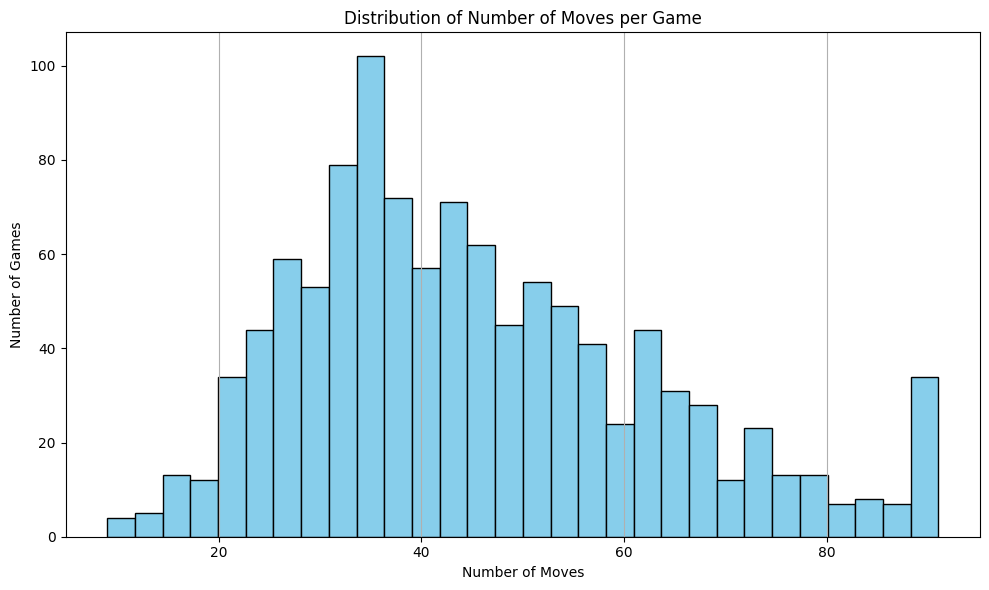

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file into a DataFrame
df = pd.read_csv(filename)

# Histogram for distribution of number of moves per game
plt.figure(figsize=(10,6))
df['number_of_moves'].hist(bins=30, edgecolor='black', color='skyblue')
plt.title('Distribution of Number of Moves per Game')
plt.xlabel('Number of Moves')
plt.ylabel('Number of Games')
plt.grid(axis='y')
plt.tight_layout()
plt.show()


In [ ]:
# Group by player_two_title and count the occurrences
title_counts = df.groupby('game_title').size()

print(title_counts)

# Filter titles with a count less than 30
# titles_less_than_30 = title_counts[title_counts < 30]

# # Display the result
# print(titles_less_than_30)

NameError: name 'df' is not defined